# Important libraries

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision.datasets import MNIST
from torchvision.models import resnet18
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# from nngeometry.metrics import FIM
# from nngeometry.object import PMatDiag, PVector
from models.models import CustomResNet18
from utils.helper import testdatasplit, compute_unlearned_predictions
from utils.mi_attack import get_membership_attack_prob
from utils.regularizer import PBU_reg

import optuna
torch.manual_seed(44)

if torch.cuda.is_available() == True:
    device = 'cuda:1'    
else:
    device = 'cpu'

## Initial Training


#### Dataset Preperation

In [5]:
# Define transformations and load MNIST dataset 
    # Correction Do the normalization of data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))])

train_dataset = MNIST(root='/home/ece/Subhodip/data', train=True, download=False, transform=transform)
test_dataset = MNIST(root='/home/ece/Subhodip/data', train=False, download=False, transform=transform)

# Set up data loaders
batch_size = 48
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

#Initial Model Training

model = CustomResNet18().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 10

/home/ece/anaconda3/envs/pt-gpu/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ece/anaconda3/envs/pt-gpu/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


#### training loop

In [97]:

for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Evaluation on the test set
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f'Epoch {epoch + 1}/{num_epochs}, Test Accuracy: {accuracy:.4f}')
    # print(f'Test Accuracy after {num_epochs} epochs: {accuracy * 100:.4f}')

# Save the trained model
torch.save(model.state_dict(), './checkpoints/resnet18_mnist.pth')


Epoch 1/10, Test Accuracy: 0.9762
Epoch 2/10, Test Accuracy: 0.9819
Epoch 3/10, Test Accuracy: 0.9878
Epoch 4/10, Test Accuracy: 0.9874
Epoch 5/10, Test Accuracy: 0.9863
Epoch 6/10, Test Accuracy: 0.9889
Epoch 7/10, Test Accuracy: 0.9908
Epoch 8/10, Test Accuracy: 0.9912
Epoch 9/10, Test Accuracy: 0.9899
Epoch 10/10, Test Accuracy: 0.9918



 For class-2

In [99]:
two_loader, non_twoloader = testdatasplit(class_number=2, testdata=test_dataset)

In [100]:
init_trained_model = CustomResNet18().to(device)
#Load the initial model state
init_model_state_dict = torch.load('/home/ece/Subhodip/Unlearning/Unlearning_NN_Repair/experiments/experiments_mnist/checkpoints/resnet18_mnist.pth')
init_trained_model.load_state_dict(init_model_state_dict)


<All keys matched successfully>

In [101]:
compute_unlearned_predictions(model=init_trained_model, three_test_loader=two_loader, 
                              nonthree_test_loader= non_twoloader)

Accuracy on Three: 99.13%
Accuracy on Non-Three: 99.19%


(0.9912790697674418, 0.9918599464763604)

For class-6

In [102]:
four_loader, non_fourloader = testdatasplit(class_number=6, testdata=test_dataset)

In [103]:
init_trained_model = CustomResNet18().to(device)
#Load the initial model state
init_model_state_dict = torch.load('/home/ece/Subhodip/Unlearning/Unlearning_NN_Repair/experiments/experiments_mnist/checkpoints/resnet18_mnist.pth')
init_trained_model.load_state_dict(init_model_state_dict)


<All keys matched successfully>

In [104]:
compute_unlearned_predictions(model=init_trained_model, three_test_loader=four_loader, 
                              nonthree_test_loader= non_fourloader)

Accuracy on Three: 99.27%
Accuracy on Non-Three: 99.17%


(0.9926931106471816, 0.9917053749170538)

For Class 8

In [105]:
eight_loader, non_eightloader = testdatasplit(class_number=8, testdata=test_dataset)

In [106]:
init_trained_model = CustomResNet18().to(device)
#Load the initial model state
init_model_state_dict = torch.load('/home/ece/Subhodip/Unlearning/Unlearning_NN_Repair/experiments/experiments_mnist/checkpoints/resnet18_mnist.pth')
init_trained_model.load_state_dict(init_model_state_dict)

<All keys matched successfully>

In [107]:
compute_unlearned_predictions(model=init_trained_model, three_test_loader=eight_loader, 
                              nonthree_test_loader= non_eightloader)

Accuracy on Three: 99.08%
Accuracy on Non-Three: 99.19%


(0.9907597535934292, 0.991912253489918)

# Retraining

For Class 8

In [108]:
retrain_model = CustomResNet18().to(device)
ret_optimizer = optim.Adam(retrain_model.parameters(), lr=0.001)


In [109]:

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    retrain_model.train()
    for images, labels in train_loader:
        # Exclude samples belonging to class 3
        non_class3_mask = labels != 8 # Assuming class 3 is labeled as 2
        images, labels = images[non_class3_mask], labels[non_class3_mask]

        images, labels = images.to(device), labels.to(device)
        ret_optimizer.zero_grad()
        outputs = retrain_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        ret_optimizer.step()

    # Evaluation on the test set after all epochs are completed
    retrain_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = retrain_model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = correct / total
    print(f'Test Accuracy after {epoch}\{num_epochs} epochs: {accuracy * 100:.4f}')

Test Accuracy after 0\10 epochs: 89.1600
Test Accuracy after 1\10 epochs: 89.0100
Test Accuracy after 2\10 epochs: 89.3000
Test Accuracy after 3\10 epochs: 89.3700
Test Accuracy after 4\10 epochs: 89.1400
Test Accuracy after 5\10 epochs: 89.3700
Test Accuracy after 6\10 epochs: 89.5600
Test Accuracy after 7\10 epochs: 89.4200
Test Accuracy after 8\10 epochs: 89.5400
Test Accuracy after 9\10 epochs: 89.2200


In [110]:
eight_loader, non_eightloader = testdatasplit(class_number=8, testdata=test_dataset)

In [111]:
compute_unlearned_predictions(model=retrain_model, three_test_loader=eight_loader, 
                              nonthree_test_loader= non_eightloader)

Accuracy on Three: 0.00%
Accuracy on Non-Three: 98.85%


(0.0, 0.9884777309993352)

For class 6

In [37]:
retrain_model = CustomResNet18().to(device)
ret_optimizer = optim.Adam(retrain_model.parameters(), lr=0.001)


In [112]:

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    retrain_model.train()
    for images, labels in train_loader:
        # Exclude samples belonging to class 3
        non_class3_mask = labels != 6 # Assuming class 3 is labeled as 2
        images, labels = images[non_class3_mask], labels[non_class3_mask]

        images, labels = images.to(device), labels.to(device)
        ret_optimizer.zero_grad()
        outputs = retrain_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        ret_optimizer.step()

    # Evaluation on the test set after all epochs are completed
    retrain_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = retrain_model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f'Test Accuracy after {num_epochs} epochs: {accuracy * 100:.4f}')

Test Accuracy after 10 epochs: 89.3700
Test Accuracy after 10 epochs: 89.8000
Test Accuracy after 10 epochs: 89.7700
Test Accuracy after 10 epochs: 89.8700
Test Accuracy after 10 epochs: 89.6800
Test Accuracy after 10 epochs: 89.7500
Test Accuracy after 10 epochs: 89.7900
Test Accuracy after 10 epochs: 89.8500
Test Accuracy after 10 epochs: 90.0200
Test Accuracy after 10 epochs: 89.0100


In [113]:
eight_loader, non_eightloader = testdatasplit(class_number=6, testdata=test_dataset)

In [114]:
compute_unlearned_predictions(model=retrain_model, three_test_loader=eight_loader, 
                              nonthree_test_loader= non_eightloader)

Accuracy on Three: 0.00%
Accuracy on Non-Three: 98.44%


(0.0, 0.9844061048440611)

Class 2

In [119]:
retrain_model = CustomResNet18().to(device)
ret_optimizer = optim.Adam(retrain_model.parameters(), lr=0.001)

In [120]:

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    retrain_model.train()
    for images, labels in train_loader:
        # Exclude samples belonging to class 3
        non_class3_mask = labels != 2 # Assuming class 3 is labeled as 2
        images, labels = images[non_class3_mask], labels[non_class3_mask]

        images, labels = images.to(device), labels.to(device)
        ret_optimizer.zero_grad()
        outputs = retrain_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        ret_optimizer.step()

    # Evaluation on the test set after all epochs are completed
    retrain_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = retrain_model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f'Test Accuracy after {num_epochs} epochs: {accuracy * 100:.4f}')

Test Accuracy after 10 epochs: 88.0500
Test Accuracy after 10 epochs: 88.6000
Test Accuracy after 10 epochs: 84.7200
Test Accuracy after 10 epochs: 88.8300
Test Accuracy after 10 epochs: 88.3100
Test Accuracy after 10 epochs: 88.8400
Test Accuracy after 10 epochs: 88.9900
Test Accuracy after 10 epochs: 89.0100
Test Accuracy after 10 epochs: 88.9400
Test Accuracy after 10 epochs: 88.7500


In [121]:
eight_loader, non_eightloader = testdatasplit(class_number=2, testdata=test_dataset)

In [122]:
compute_unlearned_predictions(model=retrain_model, three_test_loader=eight_loader, 
                              nonthree_test_loader= non_eightloader)

Accuracy on Three: 0.00%
Accuracy on Non-Three: 98.96%


(0.0, 0.9896297948260482)

# Fine Tuning

Class 2

In [123]:
finetune_model = CustomResNet18().to(device)
fin_optimizer = optim.Adam(finetune_model.parameters(), lr=0.001)
#Load the initial model state
init_model_state_dict = torch.load('/home/ece/Subhodip/Unlearning/Unlearning_NN_Repair/experiments/experiments_mnist/checkpoints/resnet18_mnist.pth')
finetune_model.load_state_dict(init_model_state_dict)


<All keys matched successfully>

In [124]:

# Fine-tuning loop
num_fine_tune_epochs = 10  # Adjust the number of fine-tuning epochs as needed
for epoch in range(num_fine_tune_epochs):
    finetune_model.train()
    for images, labels in train_loader:
        # Exclude samples belonging to class 3
        non_class3_mask = labels != 2 # Assuming class 3 is labeled as 2
        images, labels = images[non_class3_mask], labels[non_class3_mask]

        images, labels = images.to(device), labels.to(device)
        fin_optimizer.zero_grad()
        outputs = finetune_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        fin_optimizer.step()

    # Evaluation on the test set after fine-tuning
    finetune_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = correct / total
    print(f'Test Accuracy after fine-tuning: {accuracy * 100:.4f}')


Test Accuracy after fine-tuning: 99.1800
Test Accuracy after fine-tuning: 99.1800
Test Accuracy after fine-tuning: 99.1800
Test Accuracy after fine-tuning: 99.1800
Test Accuracy after fine-tuning: 99.1800
Test Accuracy after fine-tuning: 99.1800
Test Accuracy after fine-tuning: 99.1800
Test Accuracy after fine-tuning: 99.1800
Test Accuracy after fine-tuning: 99.1800
Test Accuracy after fine-tuning: 99.1800


In [125]:
eight_loader, non_eightloader = testdatasplit(class_number=2, testdata=test_dataset)

In [126]:
compute_unlearned_predictions(model=finetune_model, three_test_loader=eight_loader, 
                              nonthree_test_loader= non_eightloader)

Accuracy on Three: 0.00%
Accuracy on Non-Three: 99.14%


(0.0, 0.9914139161462979)

Class 6

In [127]:
finetune_model = CustomResNet18().to(device)
fin_optimizer = optim.Adam(finetune_model.parameters(), lr=0.001)
#Load the initial model state
init_model_state_dict = torch.load('/home/ece/Subhodip/Unlearning/Unlearning_NN_Repair/experiments/experiments_mnist/checkpoints/resnet18_mnist.pth')
finetune_model.load_state_dict(init_model_state_dict)


<All keys matched successfully>

In [128]:

# Fine-tuning loop
num_fine_tune_epochs = 10  # Adjust the number of fine-tuning epochs as needed
for epoch in range(num_fine_tune_epochs):
    finetune_model.train()
    for images, labels in train_loader:
        # Exclude samples belonging to class 3
        non_class3_mask = labels != 6 # Assuming class 3 is labeled as 2
        images, labels = images[non_class3_mask], labels[non_class3_mask]

        images, labels = images.to(device), labels.to(device)
        fin_optimizer.zero_grad()
        outputs = finetune_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        fin_optimizer.step()

    # Evaluation on the test set after fine-tuning
    finetune_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = correct / total
    print(f'Test Accuracy after fine-tuning: {accuracy * 100:.4f}')


Test Accuracy after fine-tuning: 99.1800
Test Accuracy after fine-tuning: 99.1800
Test Accuracy after fine-tuning: 99.1800
Test Accuracy after fine-tuning: 99.1800
Test Accuracy after fine-tuning: 99.1800
Test Accuracy after fine-tuning: 99.1800
Test Accuracy after fine-tuning: 99.1800
Test Accuracy after fine-tuning: 99.1800
Test Accuracy after fine-tuning: 99.1800
Test Accuracy after fine-tuning: 99.1800


In [131]:
eight_loader, non_eightloader = testdatasplit(class_number=6, testdata=test_dataset)

In [130]:
compute_unlearned_predictions(model=finetune_model, three_test_loader=eight_loader, 
                              nonthree_test_loader= non_eightloader)

Accuracy on Three: 0.00%
Accuracy on Non-Three: 99.29%


(0.0, 0.9929219199292192)

Class 8

In [132]:
finetune_model = CustomResNet18().to(device)
fin_optimizer = optim.Adam(finetune_model.parameters(), lr=0.001)
#Load the initial model state
init_model_state_dict = torch.load('/home/ece/Subhodip/Unlearning/Unlearning_NN_Repair/experiments/experiments_mnist/checkpoints/resnet18_mnist.pth')
finetune_model.load_state_dict(init_model_state_dict)


<All keys matched successfully>

In [133]:

# Fine-tuning loop
num_fine_tune_epochs = 10  # Adjust the number of fine-tuning epochs as needed
for epoch in range(num_fine_tune_epochs):
    finetune_model.train()
    for images, labels in train_loader:
        # Exclude samples belonging to class 3
        non_class3_mask = labels != 8 # Assuming class 3 is labeled as 2
        images, labels = images[non_class3_mask], labels[non_class3_mask]

        images, labels = images.to(device), labels.to(device)
        fin_optimizer.zero_grad()
        outputs = finetune_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        fin_optimizer.step()

    # Evaluation on the test set after fine-tuning
    finetune_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = correct / total
    print(f'Test Accuracy after fine-tuning: {accuracy * 100:.4f}')


Test Accuracy after fine-tuning: 99.1800
Test Accuracy after fine-tuning: 99.1800
Test Accuracy after fine-tuning: 99.1800
Test Accuracy after fine-tuning: 99.1800
Test Accuracy after fine-tuning: 99.1800
Test Accuracy after fine-tuning: 99.1800
Test Accuracy after fine-tuning: 99.1800
Test Accuracy after fine-tuning: 99.1800
Test Accuracy after fine-tuning: 99.1800
Test Accuracy after fine-tuning: 99.1800


In [134]:
eight_loader, non_eightloader = testdatasplit(class_number=8, testdata=test_dataset)

In [135]:
compute_unlearned_predictions(model=finetune_model, three_test_loader=eight_loader, 
                              nonthree_test_loader= non_eightloader)

Accuracy on Three: 0.00%
Accuracy on Non-Three: 98.88%


(0.0, 0.9888101041435852)

# Our Method

Here we take theta initial predictions - theta unlearned predictions in the matrices

### Performace of best hyperparameters 

for class -6

In [137]:
# Take the Negative/Unlearning data for class 3
negative_train_dataset = [item for item in train_dataset if item[1] == 6]
negative_train_loader = DataLoader(dataset=negative_train_dataset, batch_size=64, shuffle=True)

# Divide the test loader into 2 parts: class 3 and non-class 3
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)
test_threes_index = [i for i in range(len(test_dataset)) if test_dataset.targets[i] == 6]
test_nonthrees_index = [i for i in range(len(test_dataset)) if test_dataset.targets[i] != 6]
three_test_loader = DataLoader(test_dataset, batch_size=64, sampler=SubsetRandomSampler(test_threes_index))
nonthree_test_loader = DataLoader(test_dataset, batch_size=64, sampler=SubsetRandomSampler(test_nonthrees_index))

# Load the initial model state
init_model_state_dict = torch.load('/home/ece/Subhodip/Unlearning/Unlearning_NN_Repair/experiments/experiments_mnist/checkpoints/resnet18_mnist.pth')

# Create the initial and unlearned models
init_model = CustomResNet18()
init_model.load_state_dict(init_model_state_dict)
init_model = init_model.to(device)

unlearned_model = CustomResNet18()
unlearned_model.load_state_dict(init_model_state_dict)
unlearned_model = unlearned_model.to(device)


In [138]:
# unlearning loop
num_epochs = 5
criterion = nn.CrossEntropyLoss()

alpha = 721
beta = 90
gamma = 4001

pbu = PBU_reg(init_model=init_model, unlearned_model=unlearned_model, train_loader=negative_train_loader,
              Representation=PMatDiag, device=device)
optimizer = optim.Adam(unlearned_model.parameters(), lr=0.0001)


for epoch in range(num_epochs):
    torch.cuda.empty_cache()
    unlearned_model.train()
    running_loss = 0.0
    for inputs, labels in negative_train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = unlearned_model(inputs)
        #negative ce term
        negative_ce_loss = -criterion(outputs, labels)
        # print('negative ce loss', negative_ce_loss)
        
        # pbu penalty term
        pbu_loss = pbu.penalty()
        # print('pbu_loss', pbu_loss)
        
        # Get the PVector representation for the unlearned model
        init_pvector = PVector.from_model(init_model)
        unlearned_pvector = PVector.from_model(unlearned_model)
        # Compute the L2 loss between the initial and unlearned PVector
        l2_loss = torch.sum((init_pvector.get_flat_representation() - unlearned_pvector.get_flat_representation()) ** 2)
        # print('l2 loss', l2_loss)
        # Compute the total loss using the specified formula and hyperparameters
        
        loss = alpha * negative_ce_loss + beta * pbu_loss + gamma * l2_loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(negative_train_loader)}")

    # Compute accuracy after training
    accuracy_three, accuracy_nonthree = compute_unlearned_predictions(unlearned_model, three_test_loader, nonthree_test_loader)
    print(f"Accuracy on Three: {accuracy_three * 100:.2f}%, Accuracy on Non-Three: {accuracy_nonthree * 100:.2f}%")

Epoch 1/5, Loss: -10215.20782405074
Accuracy on Three: 0.10%
Accuracy on Non-Three: 96.24%
Accuracy on Three: 0.10%, Accuracy on Non-Three: 96.24%
Epoch 2/5, Loss: -15078.176915322581
Accuracy on Three: 0.00%
Accuracy on Non-Three: 96.99%
Accuracy on Three: 0.00%, Accuracy on Non-Three: 96.99%
Epoch 3/5, Loss: -18910.96914902554
Accuracy on Three: 0.00%
Accuracy on Non-Three: 96.95%
Accuracy on Three: 0.00%, Accuracy on Non-Three: 96.95%
Epoch 4/5, Loss: -22358.59154485887
Accuracy on Three: 0.00%
Accuracy on Non-Three: 91.10%
Accuracy on Three: 0.00%, Accuracy on Non-Three: 91.10%
Epoch 5/5, Loss: -24871.396505376346
Accuracy on Three: 0.00%
Accuracy on Non-Three: 73.86%
Accuracy on Three: 0.00%, Accuracy on Non-Three: 73.86%


For class-2

In [18]:
# Take the Negative/Unlearning data for class 3
negative_train_dataset = [item for item in train_dataset if item[1] == 2]
negative_train_loader = DataLoader(dataset=negative_train_dataset, batch_size=64, shuffle=True)

# Divide the test loader into 2 parts: class 3 and non-class 3
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)
test_threes_index = [i for i in range(len(test_dataset)) if test_dataset.targets[i] == 2]
test_nonthrees_index = [i for i in range(len(test_dataset)) if test_dataset.targets[i] != 2]
three_test_loader = DataLoader(test_dataset, batch_size=64, sampler=SubsetRandomSampler(test_threes_index))
nonthree_test_loader = DataLoader(test_dataset, batch_size=64, sampler=SubsetRandomSampler(test_nonthrees_index))

# Load the initial model state
init_model_state_dict = torch.load('/home/ece/Subhodip/Unlearning/Unlearning_NN_Repair/experiments/experiments_mnist/checkpoints/resnet18_mnist.pth')

# Create the initial and unlearned models
init_model = CustomResNet18()
init_model.load_state_dict(init_model_state_dict)
init_model = init_model.to(device)

unlearned_model = CustomResNet18()
unlearned_model.load_state_dict(init_model_state_dict)
unlearned_model = unlearned_model.to(device)

In [19]:
# Training loop
num_epochs = 5
criterion = nn.CrossEntropyLoss()

alpha = 631
beta = 100
gamma = 4001

pbu = PBU_reg(init_model=init_model, unlearned_model=unlearned_model, train_loader=negative_train_loader,
              Representation=PMatDiag, device=device)
optimizer = optim.Adam(unlearned_model.parameters(), lr=0.0001)


for epoch in range(num_epochs):
    torch.cuda.empty_cache()
    unlearned_model.train()
    running_loss = 0.0
    for inputs, labels in negative_train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = unlearned_model(inputs)
        #negative ce term
        negative_ce_loss = -criterion(outputs, labels)
        # print('negative ce loss', negative_ce_loss)
        
        # PBU penalty term
        pbu_loss = pbu.penalty()
        # print('pbu_loss', pbu_loss)
        
        # Get the PVector representation for the unlearned model
        init_pvector = PVector.from_model(init_model)
        unlearned_pvector = PVector.from_model(unlearned_model)
        # Compute the L2 loss between the initial and unlearned PVector
        l2_loss = torch.sum((init_pvector.get_flat_representation() - unlearned_pvector.get_flat_representation()) ** 2)
        # print('l2 loss', l2_loss)
        # Compute the total loss using the specified formula and hyperparameters
        
        loss = alpha * negative_ce_loss + beta * pbu_loss + gamma * l2_loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(negative_train_loader)}")

    # Compute accuracy after training
    accuracy_three, accuracy_nonthree = compute_unlearned_predictions(unlearned_model, three_test_loader, nonthree_test_loader)
    print(f"Accuracy on Three: {accuracy_three * 100:.2f}%, Accuracy on Non-Three: {accuracy_nonthree * 100:.2f}%")

Epoch 1/5, Loss: -10353.159122548204
Accuracy on Three: 0.39%
Accuracy on Non-Three: 96.71%
Accuracy on Three: 0.39%, Accuracy on Non-Three: 96.71%
Epoch 2/5, Loss: -15750.382791722075
Accuracy on Three: 0.00%
Accuracy on Non-Three: 97.62%
Accuracy on Three: 0.00%, Accuracy on Non-Three: 97.62%
Epoch 3/5, Loss: -20119.733190658244
Accuracy on Three: 0.00%
Accuracy on Non-Three: 91.96%
Accuracy on Three: 0.00%, Accuracy on Non-Three: 91.96%
Epoch 4/5, Loss: -24136.202709441488
Accuracy on Three: 0.00%
Accuracy on Non-Three: 81.86%
Accuracy on Three: 0.00%, Accuracy on Non-Three: 81.86%
Epoch 5/5, Loss: -27556.37281831782
Accuracy on Three: 0.00%
Accuracy on Non-Three: 70.42%
Accuracy on Three: 0.00%, Accuracy on Non-Three: 70.42%


For class-8

In [141]:
# Take the Negative/Unlearning data for class 3
negative_train_dataset = [item for item in train_dataset if item[1] == 8]
negative_train_loader = DataLoader(dataset=negative_train_dataset, batch_size=64, shuffle=True)

# Divide the test loader into 2 parts: class 3 and non-class 3
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)
test_threes_index = [i for i in range(len(test_dataset)) if test_dataset.targets[i] == 8]
test_nonthrees_index = [i for i in range(len(test_dataset)) if test_dataset.targets[i] != 8]
three_test_loader = DataLoader(test_dataset, batch_size=64, sampler=SubsetRandomSampler(test_threes_index))
nonthree_test_loader = DataLoader(test_dataset, batch_size=64, sampler=SubsetRandomSampler(test_nonthrees_index))

# Load the initial model state
init_model_state_dict = torch.load('/home/ece/Subhodip/Unlearning/Unlearning_NN_Repair/experiments/experiments_mnist/checkpoints/resnet18_mnist.pth')

# Create the initial and unlearned models
init_model = CustomResNet18()
init_model.load_state_dict(init_model_state_dict)
init_model = init_model.to(device)

unlearned_model = CustomResNet18()
unlearned_model.load_state_dict(init_model_state_dict)
unlearned_model = unlearned_model.to(device)

In [142]:
# Training loop
num_epochs = 5
criterion = nn.CrossEntropyLoss()

alpha = 721
beta = 100
gamma = 4001

pbu = PBU_reg(init_model=init_model, unlearned_model=unlearned_model, train_loader=negative_train_loader,
              Representation=PMatDiag, device=device)
optimizer = optim.Adam(unlearned_model.parameters(), lr=0.0001)


for epoch in range(num_epochs):
    torch.cuda.empty_cache()
    unlearned_model.train()
    running_loss = 0.0
    for inputs, labels in negative_train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = unlearned_model(inputs)
        #negative ce term
        negative_ce_loss = -criterion(outputs, labels)
        # print('negative ce loss', negative_ce_loss)
        
        # PBU penalty term
        pbu_loss = pbu.penalty()
        # print('pbu_loss', pbu_loss)
        
        # Get the PVector representation for the unlearned model
        init_pvector = PVector.from_model(init_model)
        unlearned_pvector = PVector.from_model(unlearned_model)
        # Compute the L2 loss between the initial and unlearned PVector
        l2_loss = torch.sum((init_pvector.get_flat_representation() - unlearned_pvector.get_flat_representation()) ** 2)
        # print('l2 loss', l2_loss)
        # Compute the total loss using the specified formula and hyperparameters
        
        loss = alpha * negative_ce_loss + beta * pbu_loss + gamma * l2_loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(negative_train_loader)}")

    # Compute accuracy after training
    accuracy_three, accuracy_nonthree = compute_unlearned_predictions(unlearned_model, three_test_loader, nonthree_test_loader)
    print(f"Accuracy on Three: {accuracy_three * 100:.2f}%, Accuracy on Non-Three: {accuracy_nonthree * 100:.2f}%")

Epoch 1/5, Loss: -9036.771272078804
Accuracy on Three: 0.31%
Accuracy on Non-Three: 97.91%
Accuracy on Three: 0.31%, Accuracy on Non-Three: 97.91%
Epoch 2/5, Loss: -13537.572987432066
Accuracy on Three: 0.00%
Accuracy on Non-Three: 97.74%
Accuracy on Three: 0.00%, Accuracy on Non-Three: 97.74%
Epoch 3/5, Loss: -16939.163903277855
Accuracy on Three: 0.00%
Accuracy on Non-Three: 97.20%
Accuracy on Three: 0.00%, Accuracy on Non-Three: 97.20%
Epoch 4/5, Loss: -19909.157969599186
Accuracy on Three: 0.00%
Accuracy on Non-Three: 95.49%
Accuracy on Three: 0.00%, Accuracy on Non-Three: 95.49%
Epoch 5/5, Loss: -22721.631666100544
Accuracy on Three: 0.00%
Accuracy on Non-Three: 80.22%
Accuracy on Three: 0.00%, Accuracy on Non-Three: 80.22%


### Membership Inference Attacks

class-2

In [26]:
# Take the Negative/Unlearning data for class 3
negative_train_dataset = [item for item in train_dataset if item[1] == 2]
negative_train_loader = DataLoader(dataset=negative_train_dataset, batch_size=64, shuffle=True)

# Divide the test loader into 2 parts: class 3 and non-class 3
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)
test_threes_index = [i for i in range(len(test_dataset)) if test_dataset.targets[i] == 2]
test_nonthrees_index = [i for i in range(len(test_dataset)) if test_dataset.targets[i] != 2]
three_test_loader = DataLoader(test_dataset, batch_size=64, sampler=SubsetRandomSampler(test_threes_index))
nonthree_test_loader = DataLoader(test_dataset, batch_size=64, sampler=SubsetRandomSampler(test_nonthrees_index))

# Load the initial model state
init_model_state_dict = torch.load('/home/ece/Subhodip/Unlearning/Unlearning_NN_Repair/experiments/experiments_mnist/checkpoints/resnet18_mnist.pth')

# Create the initial and unlearned models
init_model = CustomResNet18()
init_model.load_state_dict(init_model_state_dict)
init_model = init_model.to(device)

unlearned_model = CustomResNet18()
unlearned_model.load_state_dict(init_model_state_dict)
unlearned_model = unlearned_model.to(device)

/home/ece/anaconda3/envs/pt-gpu/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ece/anaconda3/envs/pt-gpu/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [34]:
get_membership_attack_prob(retain_loader=nonthree_test_loader, forget_loader=three_test_loader, 
                           test_loader=test_loader, model=unlearned_model)

0.2389

## Computational Complexity

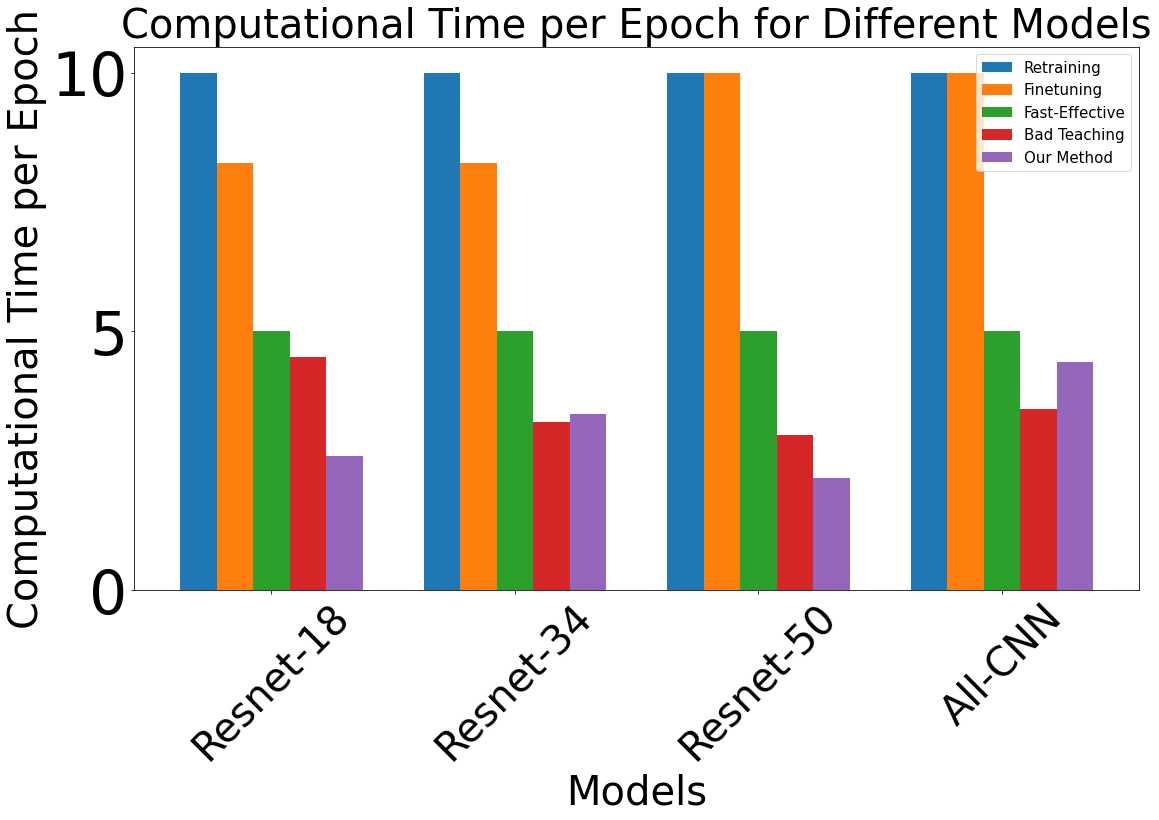

In [37]:
import torch
import torchvision.transforms as transforms
from PIL import Image
from torch import utils

import matplotlib.pyplot as plt

# Data
models = ['Resnet-18', 'Resnet-34', 'Resnet-50', 'All-CNN']
retraining = [10, 10, 10, 10]
finetuning = [8.25, 8.25, 10, 10]
fast_effective = [5, 5, 5, 5]
bad_teaching = [4.5, 3.25, 3, 3.5]
our_method = [2.6, 3.4, 2.16, 4.4]

# Creating bars
bar_width = 0.15
index = range(len(models))

fig, ax = plt.subplots(figsize=(18,10))
bar_retraining = ax.bar(index, retraining, bar_width, label='Retraining')
bar_finetuning = ax.bar([i + bar_width for i in index], finetuning, bar_width, label='Finetuning')
bar_fast_effective = ax.bar([i + 2*bar_width for i in index], fast_effective, bar_width, label='Fast-Effective')
bar_bad_teaching = ax.bar([i + 3*bar_width for i in index], bad_teaching, bar_width, label='Bad Teaching')
bar_our_method = ax.bar([i + 4*bar_width for i in index], our_method, bar_width, label='Our Method')
# Adding labels
ax.set_xlabel('Models', fontsize=40)
ax.set_ylabel('Computational Time per Epoch', fontsize=40)
ax.set_title('Computational Time per Epoch for Different Models', fontsize=40)
ax.set_xticks([i + 2 * bar_width for i in index])
ax.set_xticklabels(models, fontsize=40)
ax.legend(fontsize=15)

# Increase font size of y-axis labels
ax.tick_params(axis='y', labelsize=60)

plt.xticks(rotation=45)
# plt.tight_layout()

# Convert plot to PyTorch tensor
plt.savefig('temp_plot.png', format='png')
image = Image.open('temp_plot.png')
tensor = transforms.ToTensor()(image)

# Save as JPEG image using PyTorch
# save_image(tensor, 'computational_time_per_epoch_pytorch.pdf')

plt.show()
